In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [ ]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Wczytaj dane z folderow, podfolderow ze zdjec

In [ ]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"): #foldery jak train i val
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"): #wnetrze folderu jak cat. dog, wild. tworzy etykiete do zdjecia
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"): #zdjecie z danych podfolderow
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns = ['image_path', 'labels'])
print(data_df.head())
print(data_df["labels"].unique())

                                          image_path labels
0  /content/animal-faces/afhq/train/cat/pixabay_c...    cat
1  /content/animal-faces/afhq/train/cat/pixabay_c...    cat
2  /content/animal-faces/afhq/train/cat/pixabay_c...    cat
3  /content/animal-faces/afhq/train/cat/pixabay_c...    cat
4  /content/animal-faces/afhq/train/cat/pixabay_c...    cat
['cat' 'wild' 'dog']


podział na trening, test i walidacje

In [ ]:
train = data_df.sample(frac=0.7, random_state=42)
test = data_df.drop(train.index)
val = test.sample(frac=0.5, random_state=42)
test = test.drop(val.index)

print(f"Train size: {train.shape}")
print(f"Test size: {test.shape}")
print(f"Val size: {val.shape}")

Train size: (11291, 2)
Test size: (2419, 2)
Val size: (2420, 2)


zmiana danych na pytorch

In [ ]:
label_encoder = LabelEncoder()

#dopisanie label do naszych danych
label_encoder.fit(data_df["labels"]) #czyli zamienimy etykiety na liczbe np cat na 0

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

towrzenie dataset pytorch

In [ ]:
class CustomImageDataset(Dataset):  # Tworzymy własny zbiór danych dziedzicząc po klasie Dataset
  def __init__(self, data_frame, transform = None):  # Inicjalizacja klasy — przyjmuje DataFrame ze ścieżkami i etykietami oraz opcjonalne przekształcenia (transformacje)
    self.data_frame = data_frame  # zapisujemy DataFrame zawierający ścieżki do obrazów i etykiety
    self.transform = transform  # zapisujemy transformacje, np. augmentacje lub resize
    self.labels = torch.tensor(label_encoder.transform(self.data_frame["labels"])).to(device)  # Zamieniamy etykiety tekstowe na liczby, konwertujemy do tensora i przenosimy na GPU/CPU

  def __len__(self):  # Zwraca długość datasetu (czyli ile mamy przykładów)
    return len(self.data_frame)

  def __getitem__(self, idx):  # Pobiera jeden przykład (obraz + etykieta) o podanym indeksie idx
    image_path = self.data_frame.iloc[idx, 0]  # Pobieramy ścieżkę do obrazu z DataFrame
    label = self.labels[idx]  # Pobieramy etykietę odpowiadającą temu obrazowi
    image = Image.open(image_path).convert("RGB")  # Otwieramy obraz i konwertujemy go do formatu RGB (3 kanały)

    if self.transform:  # Jeśli podano transformacje (np. resize, augmentacje) — zastosuj je
      image = self.transform(image).to(device)

    return image, label  # Zwracamy przetworzony obraz i jego etykietę




zamiana dataset na pytorch

In [ ]:
train_dataset = CustomImageDataset(data_frame=train, transform=transform)
val_dataset = CustomImageDataset(data_frame=val, transform=transform)
test_dataset = CustomImageDataset(data_frame=test, transform=transform)

In [ ]:
train_dataset.__getitem__(78)

(tensor([[[0.1647, 0.1686, 0.1686,  ..., 0.3765, 0.2510, 0.2431],
          [0.1765, 0.1804, 0.1804,  ..., 0.3529, 0.2392, 0.2510],
          [0.1922, 0.1922, 0.2000,  ..., 0.3294, 0.2235, 0.2627],
          ...,
          [0.4863, 0.5098, 0.5451,  ..., 0.1608, 0.1529, 0.1529],
          [0.4980, 0.5294, 0.5804,  ..., 0.1569, 0.1529, 0.1529],
          [0.4941, 0.5451, 0.5922,  ..., 0.1529, 0.1451, 0.1451]],
 
         [[0.1490, 0.1529, 0.1529,  ..., 0.1020, 0.0706, 0.1020],
          [0.1529, 0.1569, 0.1569,  ..., 0.0980, 0.0627, 0.0941],
          [0.1490, 0.1529, 0.1569,  ..., 0.0902, 0.0627, 0.0980],
          ...,
          [0.3020, 0.3098, 0.3333,  ..., 0.1020, 0.0941, 0.0941],
          [0.3098, 0.3333, 0.3686,  ..., 0.0980, 0.0941, 0.0941],
          [0.3098, 0.3490, 0.3804,  ..., 0.0941, 0.0863, 0.0863]],
 
         [[0.0314, 0.0353, 0.0353,  ..., 0.0078, 0.0000, 0.0157],
          [0.0314, 0.0353, 0.0353,  ..., 0.0118, 0.0039, 0.0078],
          [0.0275, 0.0275, 0.0353,  ...,

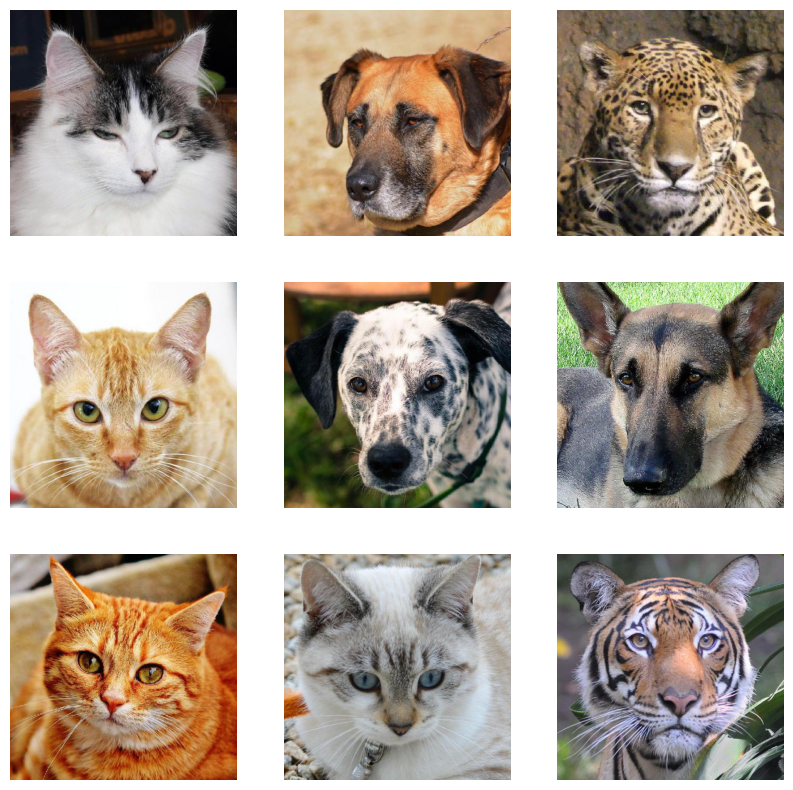

In [ ]:
n_rows = 3
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 10))
for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n=1)["image_path"].values[0]).convert("RGB")
    axes[row, col].imshow(image)
    axes[row, col].axis("off")
plt.show()

USTAWIANIE HIPER PARAMETROW DO MODELU

In [ ]:
LR = 1e-4
BATCH_SIZE = 32
EPOCHS = 10

DataLoaders

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Tworzy DataLoader do trenowania – dzieli dane na partie (batch) i losowo je tasuje przed każdą epoką
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

TWORZENIE MODELU

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()  # inicjalizacja klasy bazowej nn.Module

        # Warstwa konwolucyjna: wejście 3 kanały (RGB), wyjście 32 kanały, kernel 3x3 kernel_size=3 — rozmiar filtra 3x3
        # Kernel to mała macierz (np. 3x3), która przesuwa się po obrazie (lub mapie cech) i wykonuje operację splotu (convolution).
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) #padding=1 pomaga zachować rozmiar obrazu po konwolucji,
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Druga konwolucja: wejście 32 kanały, wyjście 64 kanały
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # Trzecia konwolucja: wejście 64, wyjście 128 kanałów

        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2) # Max pooling – redukcja wymiarów (kernel 2x2, krok 2)
        # MaxPooling zmniejsza rozmiary map cech, wybierając maksimum z każdego 2x2 obszaru, co redukuje wymiar i pomaga wydobyć istotne cechy.

        self.relu = nn.ReLU() # Funkcja aktywacji ReLU – nieliniowość
        # ReLU ustawia ujemne wartości na 0, co wprowadza nieliniowość i pozwala sieci uczyć złożonych wzorców.

        self.flatten = nn.Flatten() # Spłaszczenie obrazu przed podaniem do warstwy liniowej
        # Konwersja wielowymiarowej mapy cech do jednowymiarowego wektora, potrzebnego dla warstwy w pełni połączonej.

        self.linear1 = nn.Linear(128 * 16 * 16, 128) # Warstwa w pełni połączona – 128 kanałów, rozmiar 16x16 → 128 jednostek
        # Łączy wszystkie cechy z poprzednich warstw i tworzy 128 neuronów, które będą uczyć się kombinacji tych cech.

        self.output = nn.Linear(128, len(data_df['labels'].unique())) # Warstwa wyjściowa – liczba klas = liczba unikalnych etykiet
        # Ostatnia warstwa, która mapuje 128 neuronów na liczbę klas, czyli rozmiar wyjścia odpowiada liczbie etykiet do rozpoznania.

        self.dropout_con  = nn.Dropout2d(0.1)
        self.dropout_lin = nn.Dropout(0.2)


    def forward(self, x):
        x = self.conv1(x) # -> (32, 128, 128)
        # Pierwsza konwolucja: filtruje wejście, tworząc 32 mapy cech.
        x = self.pooling(x) # -> (32, 64, 64)
        # Zmniejszenie wymiarów map cech przez max pooling (redukcja połowy rozmiaru).
        x = self.relu(x)
        # Nieliniowa aktywacja, która umożliwia sieci uczenie bardziej złożonych funkcji.
        x = self.dropout_con(x)

        x = self.conv2(x) # -> (64, 64, 64)
        # Druga konwolucja: tworzy 64 mapy cech na podstawie poprzednich.
        x = self.pooling(x) # -> (64, 32, 32)
        # Ponowna redukcja wymiarów przez pooling.
        x = self.relu(x)
        x = self.dropout_con(x)

        x = self.conv3(x) # -> (128, 32, 32)
        # Trzecia konwolucja: tworzy 128 map cech.
        x = self.pooling(x) # -> (128, 16, 16)
        # Redukcja wymiarów do 16x16 na mapę cech.
        x = self.relu(x)
        x = self.dropout_con(x)

        x = self.flatten(x) # -> (16384)
        # Spłaszcza mapy cech do wektora o długości 128*16*16=16384, przygotowując do warstwy liniowej.
        x = self.linear1(x) # -> (128)
        # Przekształca wektor cech do 128-elementowego wektora reprezentacji.
        x = self.dropout_lin(x)

        x = self.output(x)
        # Wyjście sieci, liczba neuronów równa liczbie klas.


        return x




model summary

In [ ]:
model = Net().to(device)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
         Dropout2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
         MaxPool2d-6           [-1, 64, 32, 32]               0
              ReLU-7           [-1, 64, 32, 32]               0
         Dropout2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
        MaxPool2d-10          [-1, 128, 16, 16]               0
             ReLU-11          [-1, 128, 16, 16]               0
        Dropout2d-12          [-1, 128, 16, 16]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                  [

Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

treningm modelu

In [ ]:
total_loss_train_plot = [] #strata
total_loss_val_plot = []
total_acc_train_plot = [] #dokładność
total_acc_val_plot = []

# Główna pętla treningowa – iteracja po epokach
for epoch in range(EPOCHS):
  # Zerowanie sumatorów dla danej epoki
  total_loss_train = 0.0
  total_acc_train = 0.0
  total_loss_val = 0.0
  total_acc_val = 0.0

  # Pętla po batchach treningowych
  for inputs, labels in train_loader:
    optimizer.zero_grad()  # Zerowanie gradientów przed każdą aktualizacją

    outputs = model(inputs)  # Przekazanie danych przez model (forward pass)

    train_loss = criterion(outputs, labels)  # Obliczenie straty
    total_loss_train += train_loss.item()    # Dodanie wartości straty (float) do sumy

    train_loss.backward()  # Propagacja wsteczna – obliczenie gradientów

    # Obliczenie liczby poprawnie sklasyfikowanych próbek
    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc

    optimizer.step()  # Aktualizacja wag modelu na podstawie gradientów

  # Walidacja (bez aktualizacji wag)
  with torch.no_grad():  # Wyłączenie autograd – oszczędność pamięci i czasu
    for inputs, labels in val_loader:
      outputs = model(inputs)  # Forward pass na zbiorze walidacyjnym

      val_loss = criterion(outputs, labels)  # Strata walidacyjna
      total_loss_val += val_loss.item()

      # Obliczenie dokładności walidacyjnej
      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
      total_acc_val += val_acc

    #rysowanie wykresów normalizacja ogromnych liczb przez 1000

  fin_total_loss_train = round(total_loss_train /1000, 4)
  fin_total_loss_val = round(total_loss_val /1000, 4)
  fin_total_acc_train = round(total_acc_train /train_dataset.__len__() * 100, 4)
  fin_total_acc_val = round(total_acc_val /val_dataset.__len__() * 100, 4)


  total_loss_train_plot.append(fin_total_loss_train)
  total_loss_val_plot.append(fin_total_loss_val)
  total_acc_train_plot.append(fin_total_acc_train)
  total_acc_val_plot.append(fin_total_acc_val)

  print(f'''Epoch no. {epoch + 1} Train Loss: {fin_total_loss_train} Train Accuracy: {fin_total_acc_train} Validation Loss: {fin_total_loss_val} Validation Accuracy: {fin_total_acc_val}''')
  print("="*25)


Epoch no. 1 Train Loss: 0.2147 Train Accuracy: 73.3859 Validation Loss: 0.0262 Validation Accuracy: 87.7273
Epoch no. 2 Train Loss: 0.1106 Train Accuracy: 88.327 Validation Loss: 0.0204 Validation Accuracy: 90.2479
Epoch no. 3 Train Loss: 0.0858 Train Accuracy: 91.0902 Validation Loss: 0.0187 Validation Accuracy: 90.9091
Epoch no. 4 Train Loss: 0.068 Train Accuracy: 93.0387 Validation Loss: 0.0145 Validation Accuracy: 93.4298
Epoch no. 5 Train Loss: 0.0541 Train Accuracy: 94.562 Validation Loss: 0.0133 Validation Accuracy: 93.843
Epoch no. 6 Train Loss: 0.0447 Train Accuracy: 95.5983 Validation Loss: 0.0118 Validation Accuracy: 94.4215
Epoch no. 7 Train Loss: 0.035 Train Accuracy: 96.4839 Validation Loss: 0.0102 Validation Accuracy: 94.7934
Epoch no. 8 Train Loss: 0.0303 Train Accuracy: 97.2279 Validation Loss: 0.0114 Validation Accuracy: 94.9174
Epoch no. 9 Train Loss: 0.0254 Train Accuracy: 97.5201 Validation Loss: 0.0108 Validation Accuracy: 95.0413
Epoch no. 10 Train Loss: 0.0214 T

test naszego modelu

In [ ]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0

  for inputs, labels in test_loader:
    pred = model(inputs)

    acc = (torch.argmax(pred, axis=1) == labels).sum().item()
    total_acc_test += acc

    loss = criterion(pred, labels)
    total_loss_test += loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 95.4113 and Loss is 0.0097


wykresy

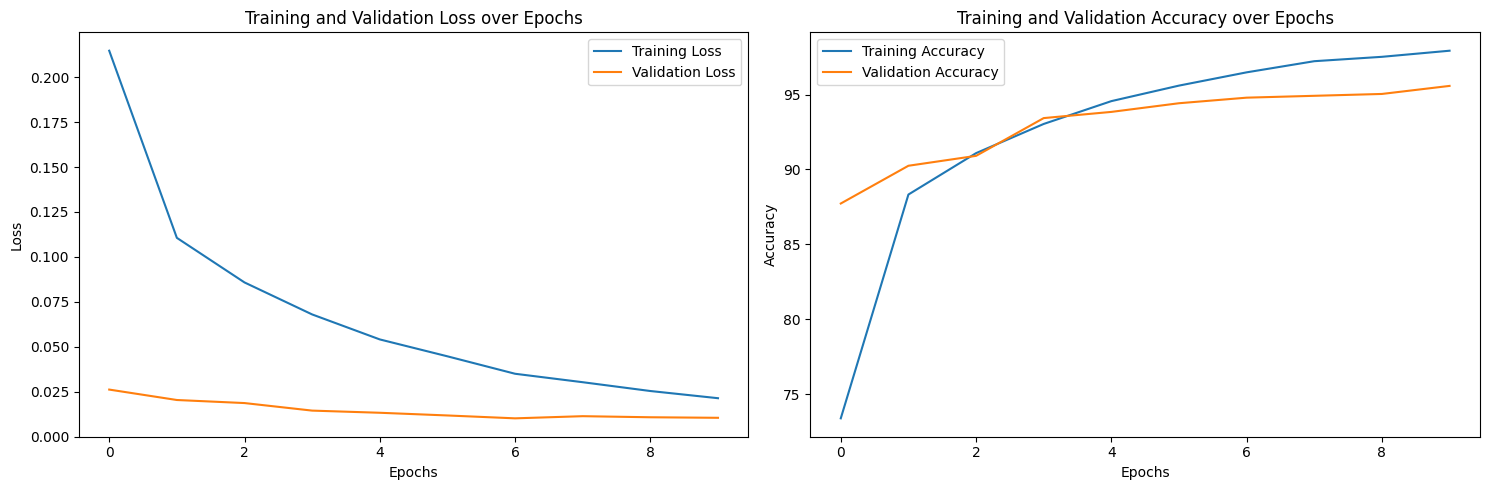

In [ ]:
ig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_val_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
#axs[0].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_val_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
#axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

Model osiąga bardzo dobrą dokładność (~99% trening, ~96% walidacja), ale od około 5. epoki zaczyna wykazywać oznaki lekkiego przeuczenia, co sugeruje potrzebę zastosowania regularizacji np dodanie dropout.

Po dodaniu dropout do modelu i zmniejszenie liczby epok dokladnosc spadla lecz walidacja się polepszyła co pozwoliło na uzyskaniu dobrych wyników


test modelu na psie o imieniu NIKI

In [ ]:
def pred_image(img_path):
  image = Image.open(img_path).convert("RGB")
  plt.imshow(image)
  plt.show()
  image = transform(image).to(device)
  #print(image.shape)
  output  = model(image.unsqueeze(0))
  print(output)
  output = torch.argmax(output, axis=1).item()
  label_output = label_encoder.inverse_transform([output])

  return label_output

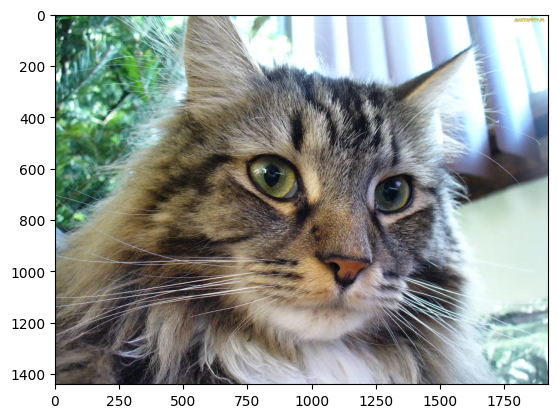

tensor([[ 8.4130, -4.5415,  0.3317]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


array(['cat'], dtype=object)

In [ ]:
pred_image('/content/glowa_kot.jpg')

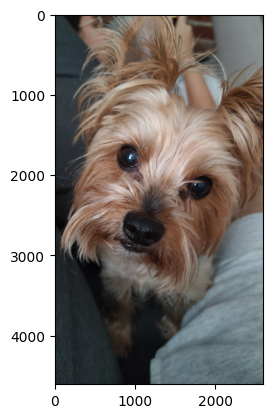

tensor([[-2.4169,  3.3532, -0.4689]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


array(['dog'], dtype=object)

In [ ]:
pred_image('/content/glowa_nikus.jpg')

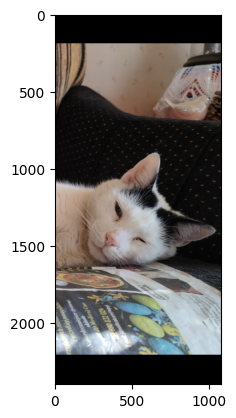

tensor([[ 6.4838, -2.8549, -1.8699]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


array(['cat'], dtype=object)

In [ ]:
pred_image('/content/glowa_duzego_kota.jpg')